In [1]:
import torch
import torch.nn.functional as F 
from torch_geometric.datasets import WikiCS,  CitationFull,  Coauthor
from utils import count_out_degree, make_adj_matrix, count_in_degree
import math
import random

In [2]:
dataset = Coauthor('.', 'CS')
data = dataset[0]  

In [4]:
data.x = -torch.ones(data.x.shape[0], 3)

In [4]:
cnts = count_out_degree(data) + count_in_degree(data)
data.x[:, 0] = cnts

In [5]:
def create_pointer_graph(graph):
    l = [([], []) for i in range(graph.num_nodes)]
    for fromx, tox in zip(graph.edge_index[0], graph.edge_index[1]):
        l[fromx][0].append(tox.item())
        l[tox][1].append(fromx.item())
    return l
pointer_graph = create_pointer_graph(data)

In [6]:
def get_in_out_ego_edges(ego_node, pointer_graph):
    #counts in edges twice and only out out edges no out in edges 
    inedges, outedges = 0, 0
    ego_net_dict = {}
    ego_net_dict[ego_node] = 1
    from itertools import chain
    for node in chain(pointer_graph[ego_node][0], pointer_graph[ego_node][1]):
        inedges += 1
        ego_net_dict[node] = 1

    for node in chain(pointer_graph[ego_node][0], pointer_graph[ego_node][1]):
        for node2 in chain(pointer_graph[node][0], pointer_graph[node][1]):
            if node2 in ego_net_dict:
                inedges += 1
            else:
                outedges += 1
    return inedges, outedges
for node, row in enumerate(data.x):
    row[1], row[2] = get_in_out_ego_edges(node, pointer_graph)

In [8]:
data.x = (data.x - data.x.mean(dim=0))/data.x.std(dim=0)

In [9]:
data.x

tensor([[-0.4162, -0.3943, -0.5331],
        [-0.5374, -0.4004, -0.5261],
        [-0.4933, -0.3971, -0.2851],
        ...,
        [ 0.7404,  0.3272,  0.8431],
        [-0.5484, -0.4008, -0.7675],
        [-0.4162, -0.3806, -0.7835]])

In [11]:
sims_mat = data.x @ data.x.t()

In [12]:
data.x2 = (data.x - data.x.mean(dim=0))/data.x.std(dim=0)
sims = torch.nn.CosineSimilarity(dim=1)(data.x2, data.x2[random.randint(0, data.num_nodes-1)].unsqueeze(0))
torch.topk(sims, k=10, dim=0)

torch.return_types.topk(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        0.9999]),
indices=tensor([11288,  2712, 11302,   766,   327,  4566,  2897,  6475, 10112,   266]))

In [13]:
def agregate_sum_mean(pointer_graph, data, niter):
    for i in range(niter):
        datalist = []
        for node in range(data.num_nodes):
            l = pointer_graph[node][1]
            idx = torch.tensor(l, dtype=torch.long)
            vec = data.x[idx]
            sum, mean = vec.sum(dim=0), vec.mean(dim=0)
            datalist.append(torch.cat((data.x[node], mean, sum)).unsqueeze(0))
            print((i+1)/niter*(node+1)/data.num_nodes, "%", end='\r')
        # print(datalist)
        data.x = torch.cat(datalist, dim=0)
agregate_sum_mean(pointer_graph, data, 2)

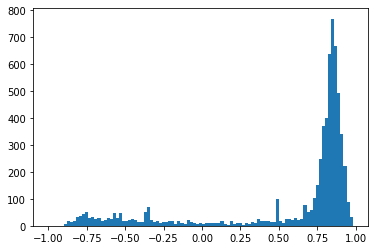

In [29]:
import matplotlib.pyplot as plt
import random
import numpy as np
data.x2 = (data.x - data.x.mean(dim=0))/data.x.std(dim=0)
data.x2 = data.x
sims = data.x2 @ data.x2[0].unsqueeze(0).t()
numnode = random.randint(0, data.num_nodes-1)
sims = torch.nn.CosineSimilarity(dim=1)(data.x2, data.x2[numnode].unsqueeze(0))
bins = np.array(list(range(0, 100)))/50 - 1
plt.hist(sims.numpy(), bins); #, bins

In [151]:
svi = torch.zeros(len(bins)+1).long()-1
print(svi.shape)
for i, nes in enumerate(np.digitize(sims, bins)):
    svi[nes] = i
    # print(svi[nes], nes)
svi

torch.Size([101])


tensor([   -1, 10802,  4054,  9969,  5611,  9912, 11495, 10770, 10893, 11183,
        11545, 11484, 11655, 10477, 11331, 11229, 10662, 11590, 11583, 11459,
        11646, 11388, 11677, 11638, 11255, 11678, 11498, 11683, 11649, 11282,
        10750, 11538, 11413, 11466, 11675, 10900, 11570, 11521, 11349, 11643,
        11622, 11391, 11686, 10557, 11673, 11700, 11695, 11627, 11696, 11699,
        11697, 11684, 11687, 11698, 11690, 11682, 11650, 11621, 11594, 11460,
        11681, 11667, 11553, 11630, 11693, 11685, 11580, 11691, 11520, 11327,
        11656, 11669, 11674, 11574, 11615, 11524, 11635, 11659, 11636, 11672,
        11248, 11663, 11576, 11543, 11130, 11657, 11245, 11647, 11607, 11596,
        11670, 11568, 11688, 11633, 11664, 11528, 11632, 11603, 11689, 11661,
        11641])

In [155]:
a, b = pointer_graph[int(svi[].item())]
len(a), len(b)

(8, 62)

In [81]:
pointer_graph[int(svi[numnode].item())], numnode

(([5083, 7586, 5083],
  [1916, 2293, 2826, 3210, 4182, 5083, 5914, 7586, 8454, 11306]),
 6323)

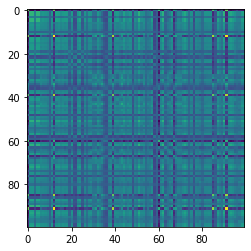

In [33]:
spec = data.x2[:100]
sims_mat = spec@spec.t()
plt.imshow(sims_mat.numpy())